In [22]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


#metrics
from sklearn.metrics import mean_squared_error

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

# custom functions
import functions

# Market Data Gathering

In [2]:
# Important dates
start = dt.datetime(2017,8,6)
end = dt.datetime(2022,8,6)


In [3]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

In [4]:
# concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', gspc, 'gspc_')

In [5]:
# remove test data from train
train, test = functions.testSplit(features)

# Feature Engineering

In [82]:
# features we are keeping
feature_cols = ['nflx_Adj Close', 'gspc_Adj Close', 'nflx_Volume']

In [83]:
# Establish variables and target
nflx_target = 'nflx_Adj Close'
gspc_target = 'gspc_Adj Close'

# Remove target variable
# x_train = functions.dropTarget(train, nflx_target)
# x_test = functions.dropTarget(test, nflx_target)
x_train = train[feature_cols]
x_test = test[feature_cols]
y_train = train[nflx_target]
y_test = test[nflx_target]

In [84]:
# function transformers aren't working for pandas timeshift, storing them here for now.
# # function transform nflx engineering functions
# t_shiftTime = FunctionTransformer(functions.shiftTime)
# t_rollingMeanShift = FunctionTransformer(functions.rollingMeanShift(train))
# t_trendDiff = FunctionTransformer(functions.trendDiff(train))

# # drop target variable
# t_dropTarget = FunctionTransformer(functions.dropTarget)


In [85]:
# feature_engineering = Pipeline([
#     ('t_nflx_shiftTime', functions.shiftTime),
#     # ('t_nflx_rollingMeanShift', t_rollingMeanShift),
#     # ('t_nflx_trendDiff', t_trendDiff)
#     ])

In [86]:
# shift all values by one time step
# train = functions.shiftTime(train, 3).dropna()

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2017-08-07 to 2021-08-06
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nflx_High       1008 non-null   float64
 1   nflx_Low        1008 non-null   float64
 2   nflx_Open       1008 non-null   float64
 3   nflx_Close      1008 non-null   float64
 4   nflx_Volume     1008 non-null   int64  
 5   nflx_Adj Close  1008 non-null   float64
 6   gspc_High       1008 non-null   float64
 7   gspc_Low        1008 non-null   float64
 8   gspc_Open       1008 non-null   float64
 9   gspc_Close      1008 non-null   float64
 10  gspc_Volume     1008 non-null   int64  
 11  gspc_Adj Close  1008 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 102.4 KB


In [109]:
pipeline = Pipeline([
    # ('feature_engineering', feature_engineering),
    ('t_nflx_shiftTime', functions.shiftTime(rolling=7)),
    ('Imputer', SimpleImputer()),
    ('scaling', StandardScaler()),
    # ('PCA', PCA(n_components=5)),
    # ('selectKBest', SelectKBest(f_regression,k=2)),
    ('classifier', Ridge()),
    ])

In [110]:
functions.shiftTime(x_train)

shiftTime(rolling=            nflx_Adj Close  gspc_Adj Close  nflx_Volume
Date                                                   
2017-08-07      181.330002     2480.909912      4609800
2017-08-08      178.360001     2474.919922      6104000
2017-08-09      175.779999     2474.020020      9670500
2017-08-10      169.139999     2438.209961      9693100
2017-08-11      171.399994     2441.320068      5022300
...                    ...             ...          ...
2021-08-02      515.150024     4387.160156      2096600
2021-08-03      510.820007     4423.149902      2579400
2021-08-04      517.349976     4402.660156      2039400
2021-08-05      524.890015     4429.100098      2556700
2021-08-06      520.549988     4436.520020      1919800

[1008 rows x 3 columns])

In [111]:
model = pipeline.fit(x_train, y_train)

In [112]:
y_pred = model.predict(x_test)

In [113]:
mean_squared_error(y_test, y_pred)

302.9879690556053

In [114]:
pred_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)

<AxesSubplot:xlabel='Date'>

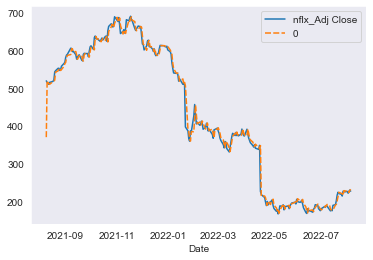

In [115]:
sns.lineplot(data=pred_df)

In [116]:
model.steps[2][1].get_feature_names_out(x_train.columns)

array(['nflx_Adj Close', 'gspc_Adj Close', 'nflx_Volume'], dtype=object)

In [72]:
model.steps

[('t_nflx_shiftTime', shiftTime(rolling=3)),
 ('Imputer', SimpleImputer()),
 ('scaling', MinMaxScaler()),
 ('selectKBest',
  SelectKBest(k=2, score_func=<function f_regression at 0x0000016F8AFE2C10>)),
 ('classifier', LinearRegression())]